# Урок 6. Градиентный бустинг

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
# Число деревьев в ансамбле
n_trees = 100
# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.01
# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [11]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 2566.4482441731425
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 4262.345012231075


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [13]:
import matplotlib.pyplot as plt

In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

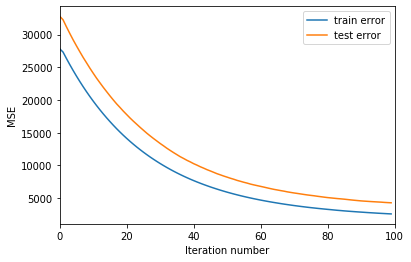

In [15]:
get_error_plot(n_trees, train_errors, test_errors)

### Домашнее задание:  
1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  

In [16]:
train_errors = []
test_errors = []
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 21):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

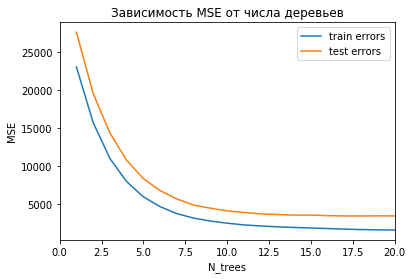

In [17]:
x = list(range(1, 21))

plt.xlim(0, 20)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.title('Зависимость MSE от числа деревьев')
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [18]:
train_errors = []
test_errors = []
n_trees = 10
coefs = [1] * n_trees
eta = 0.1

for max_depth in range(1, 51):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

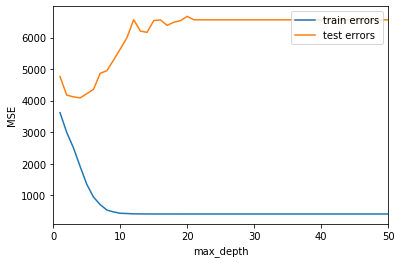

In [19]:
x = list(range(1, 51))

plt.xlim(0, 50)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

##### Вывод по задаче 1: В градиентном бустинге деревья должны быть короткими и неглубокими. В доказательство мы увеличили глубину деревьев до 51 и это привело к переобучению модели. 

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [20]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, rand_sample_size=0.5):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Рандомный выбор половины индексов
            to_choice = list(range(X_train.shape[0]))
            train_ind = np.random.choice(to_choice, size=int(0.5*len(to_choice)))
            
            # Получим ответы на текущей выбранной композиции
            target = gb_predict(X_train[train_ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на остатки, но не по всей выборке, а только по части
            tree.fit(X_train[train_ind], deriv(y_train[train_ind], target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [21]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 3
eta = 0.2

trees, train_errors_s, test_errors_s = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [22]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

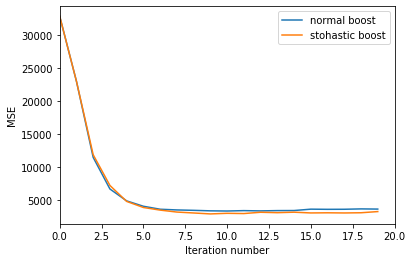

In [24]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label='normal boost')
plt.plot(list(range(n_trees)), test_errors_s, label='stohastic boost')
plt.legend(loc='upper right')
plt.show();

###### Вывод по задаче 2: Кривые изменения ошибки MSE при нормальном и стохастическом бустингах представлены на графике.